# Overview: What contributes to property prices in the Boston area?

We're going to analyze a dataset that contains nearly 1000 different condos and houses available for sale circa 2021 in the Boston area. Based on the features of a place and it's location we will try to predict its price.

In [1]:
import pandas as pd

df_boston = pd.read_csv('boston_houses.csv', index_col=None)

df_boston.head()

,beds,baths,area,distance,price,price_bucket
0,3.0,2.0,2584.0,18.726140,1100000.0,price >= 900k
1,1.0,1.0,650.0,1.053808,699000.0,600k <= price < 900k
2,2.0,3.0,1794.0,0.471038,1750000.0,price >= 900k
3,4.0,3.0,1831.0,3.611435,979000.0,price >= 900k
4,3.0,3.0,1875.0,2.200608,1875000.0,price >= 900k


# Part 1: Decision Tree Classifier (21 points)
Our desired target variable is continuous (`price`), though our classifiers require a categorical target (e.g. `species`).  To remedy this, we have first "binned" `price` into three buckets:

In [2]:
df_boston['price_bucket'].value_counts()

price < 600k            321
price >= 900k           320
600k <= price < 900k    313
Name: price_bucket, dtype: int64

1. Build a Decision Tree with `max_depth=2` which estimates the `price_bucket` of housing using 
    - beds
    - baths
    - area
    - distance
1. Plot the tree using [plot_tree()](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html).  To ensure the visualization is easily understood:
    - increase the size of the figure so text is easily read
    - utlize the `class_names` keyword input to `plot_tree()` which shows the most common class among the `values` shown
1. Validate your tree by identifying one intuitive behavior which it replicates (e.g. larger houses tend to be more expensive)
    - Remember the convention for reading the tree:
        - yes -> left
        - no -> right
        - after training, `dec_tree_clf.classes_` contains the order of classes shown in the `values` lists shown in the tree
    - Please summarize the intuition identified in the tree in a markdown cell just below the tree itself


In [3]:
#1 build a decision tree
import seaborn as sns
from sklearn import tree
import matplotlib.pyplot as plt

# specify max depth and x features
max_depth = 2
x_feat_list = ['beds', 'baths', 'area', 'distance']

# extract data
x = df_boston.loc[:, x_feat_list].values
y = df_boston.loc[:, 'price_bucket'].values

# build decision tree classifier
dec_tree_clf = tree.DecisionTreeClassifier(max_depth=max_depth)

# fit data
dec_tree_clf.fit(x, y)

DecisionTreeClassifier(max_depth=2)

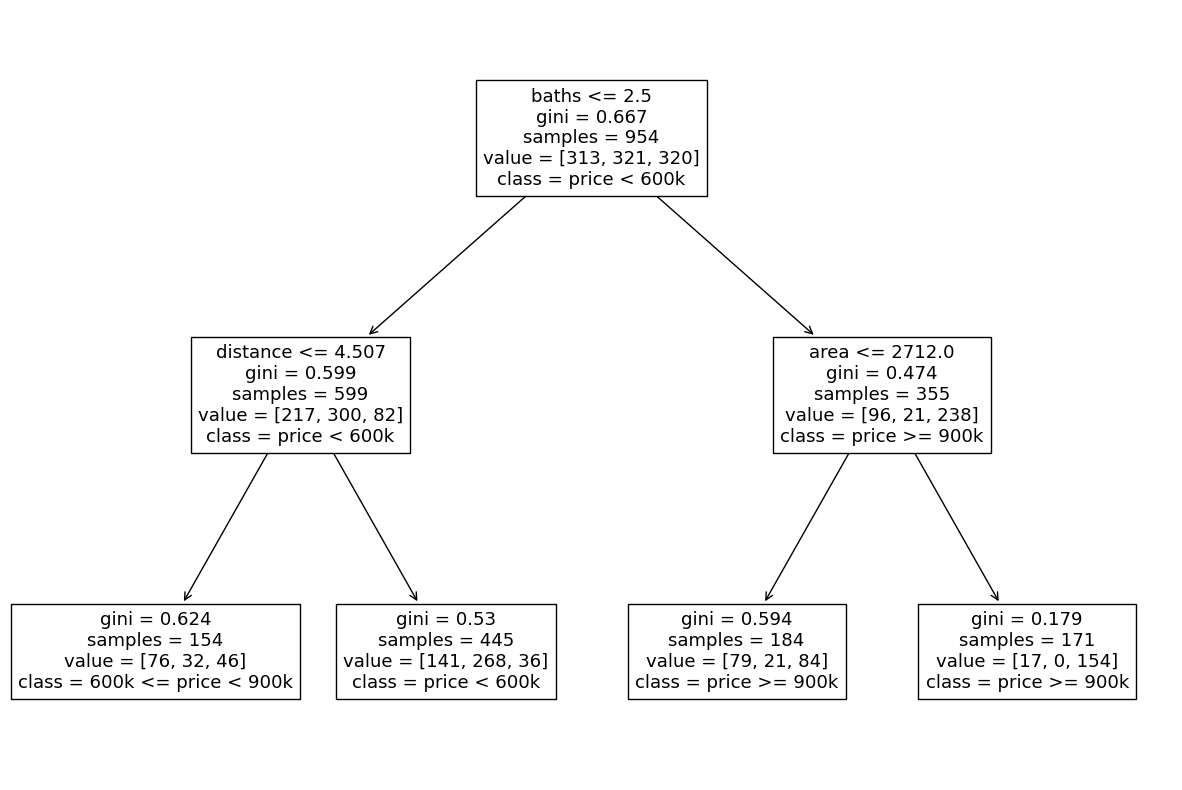

In [4]:
#2 plot decision tree

# initialize figure and set size
plt.figure()
plt.gcf().set_size_inches(15, 10)

# plot the tree
tree.plot_tree(dec_tree_clf, 
               feature_names=x_feat_list,
               class_names=dec_tree_clf.classes_);

### #3 validate tree
The above decision tree classifier is valid as houses with 2.5 bathrooms or less were less expensive (less than 600k) than houses with more bathrooms which were more than 600k. If houses have more bathrooms, they tend to have more bedrooms as well, so intuitively, bigger houses should cost more which is accurately represented above. 

# Part 2: Random Forest Classification (23 points)
We'd like to quantify how significant each feature (i.e. 'beds', 'baths', 'area', 'distance') is in predicting the `price_bucket` of a property via a Random Forest Analysis.  Of course:

# Nobody cares which features are important to a classifier which doesn't work!

so, before we look at feature importance we must check that our classifier is able to predict `price_bucket` with reasonable accuracy (hint: the solution shows 70% accuracy, which is sufficient for our purposes here).

Using 10 fold cross validation with a Random Forest (max_depth=3) and the same x, y definitions as above:
- construct a confusion matrix which shows performance
- compute accuracy via [accuracy_score()](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

Text(0.5, 0.98, 'Random Forest Classifier with 10 fold cross validation')

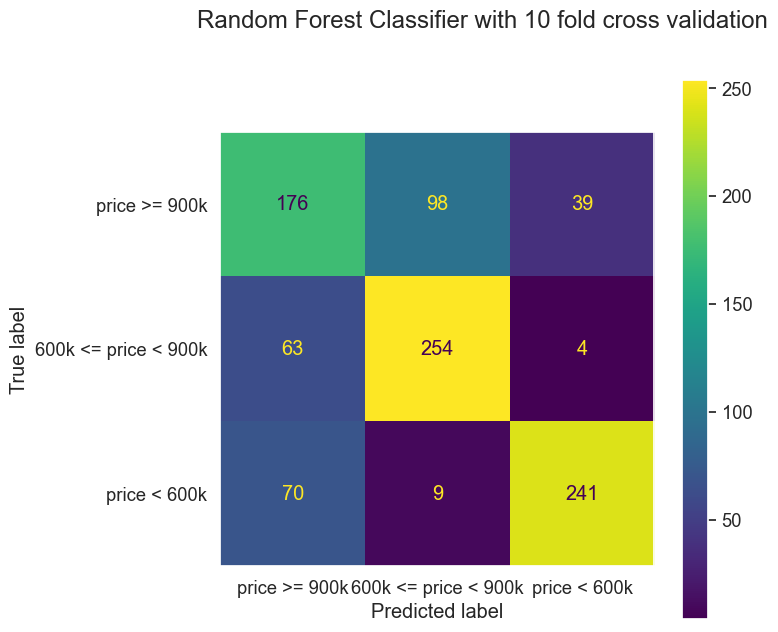

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# specify max depth and n splits
n_splits = 10
max_depth = 3

# specify target feature
y_feat_list = df_boston.loc[:, 'price_bucket'].unique()

# initialize k fold
skfold = StratifiedKFold(n_splits=n_splits)

# initialize random forest
dec_tree_clf = RandomForestClassifier(max_depth=max_depth)

# initialize predictions of y
y_pred = np.empty_like(y)

# split test / training data 
for train_idx, test_idx in skfold.split(x, y):
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    #test data    
    x_test = x[test_idx, :]
    
    # fit data
    dec_tree_clf = dec_tree_clf.fit(x_train, y_train)
    
    # estimate on test data
    y_pred[test_idx] = dec_tree_clf.predict(x_test)
    

# build and plot confusion matrix
sns.set(font_scale=1.2)
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=y_feat_list)
conf_mat_disp.plot()
plt.gcf().set_size_inches(7, 7)
plt.grid(False)
plt.suptitle('Random Forest Classifier with 10 fold cross validation')

In [6]:
from sklearn.metrics import accuracy_score

# accuracy score calculated
accuracy_score(y, y_pred)

0.7033542976939203

# Part 3 Feature Importance in Random Forest (16 points)
1. Fit a Random Forest Classifier on the *entire dataset.  
    - *without k-fold Cross Validation ...
1. Plot the Feature Importances, mean reduction in Gini scores, via `plot_feat_import()`
    - copy this function from class notes as is (no need to cite here)
1. In a markdown cell just below your feature importance plot:
    - synthesize the key takeaway message of the plot
        - write 1 or 2 complete sentences here
    - From the feature importance plot alone can we determine whether housing prices go up as the `area` increases?
        - write 1 complete sentence here    

In [7]:
# build random forest classifier and fit
rf_clf = RandomForestClassifier(max_depth = max_depth)
rf_clf.fit(x, y)

RandomForestClassifier(max_depth=3)

In [8]:
# function to plot feature importance is copied
def plot_feat_import(feat_list, feat_import, ml_type, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        ml_type (str): type of machine learning model
        sort (bool): if True, sorts features in decreasing importance
            from top to bottom of plot
        limit (int): if passed, limits the number of features shown
            to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]
    
    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(5, len(feat_list) / 2)
    
    # function updated to accurately label x axis based on if it is a RandomForestClassifier or RandomForestRegressor
    if ml_type == 'classifier':
        plt.xlabel('Feature importance\n(Mean decrease in Gini across all Decision Trees)')
    elif ml_type == 'regressor':
        plt.xlabel('Feature importance\n(Mean decrease in mean squared error across all Decision Trees)')

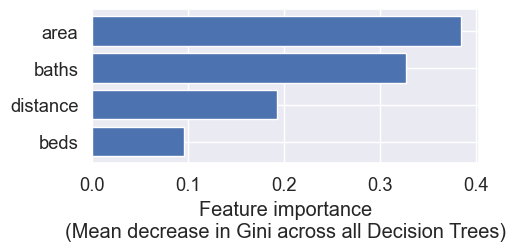

In [9]:
# set scale 
sns.set(font_scale=1.2)

# plot feature importance
plot_feat_import(x_feat_list, rf_clf.feature_importances_, 'classifier')

### Key Takeaway
From the feature importance graph, we can conclude that area of the house has the most weight, closely followed by number of bathrooms, in deciding what price group the house falls under. On the other hand, distance to downtown and number of beds has the least impact on house pricing.

Even though area is correlated with the price bucket of the property, it is not enough to say that solely a change in area will cause a change in housing prices. 

# Part 4: `RandomForestRegressor` and housing prices
In earlier parts of this HW, we used a `DecisionTree` and `RandomForestClassifier` to predict `price_bucket`.  Here we use a `RandomForestRegressor` to predict the housing `price` (not just the `price_bucket`).

See [this video](https://youtu.be/SiovCeiKuSY) (same as for lab5) for an "introduction" to `RandomForestRegressor`.

## Part 4.1: Compute a cross validated $R^2$ for a `RandomForestRegressor` (9 points)
    ... nobody cares which features are important in a regression model which can't predict accurately

In [10]:
import pandas as pd

df_house = pd.read_csv('boston_houses.csv', index_col=None)

df_house.head()

,beds,baths,area,distance,price,price_bucket
0,3.0,2.0,2584.0,18.726140,1100000.0,price >= 900k
1,1.0,1.0,650.0,1.053808,699000.0,600k <= price < 900k
2,2.0,3.0,1794.0,0.471038,1750000.0,price >= 900k
3,4.0,3.0,1831.0,3.611435,979000.0,price >= 900k
4,3.0,3.0,1875.0,2.200608,1875000.0,price >= 900k


In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

# extract data
y = df_house.loc[:, 'price'].values

# Initialize the regressor
rfr = RandomForestRegressor()

# Initialize the k-fold cross validation object
kf = KFold(n_splits=10)

# Initialize empty list to store the R-squared
r2_scores = []

# initialize predictions of y
y_pred = np.empty_like(y)

# Loop over the folds of the k-fold cross validation object
for train_idx, test_idx in kf.split(x, y):
    # Split the data into training and testing sets for this fold
    x_train = x[train_idx, :]
    y_train = y[train_idx]
    
    #test data    
    x_test = x[test_idx, :]

    # Fit the regressor on the training data for this fold
    rfr.fit(x_train, y_train)

    # Use the regressor to make predictions on the testing data for this fold
    y_pred[test_idx] = rfr.predict(x_test)

    
# Compute the R-squared score
r2_score(y, y_pred)

0.7244312516997793

## Part 4.2. Plot the feature importances of your `RandomForestRegressor` (8 points)

You should update `plot_feat_import()` to properly label the x axis.  (`RandomForestClassifier`s minimize Gini, what do `RandomForestRegressor`s minimize?)

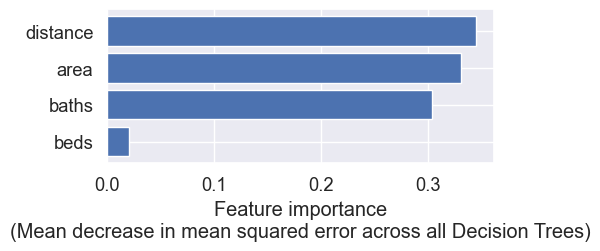

In [12]:
# set scale 
sns.set(font_scale=1.2)

# plot feature importance (function updated in part 3)
plot_feat_import(x_feat_list, rfr.feature_importances_, 'regressor')

## Part 4.3 Regressor vs Classifier? (7 points) 
Between the `RandomForestRegressor`s and `RandomForestClassifier`, explain which feature importance graph you trust more.

### hints: 
- does the `RandomForestClassifier` distinguish between different house prices within a single bucket?
- wasn't our choice of 3 buckets somewhat arbitrary?  What if we used 10 price buckets instead, this can change the feature importances ... 

The `RandomForestRegressor` is more trustworthy because it more accurately captures the precise relationship between features and individual price whereas the `RandomForestClassifier` only finds a relationship between a wide range of prices of a property and the features. If the price buckets for the classifier are made smaller in range, then as the price buckets decrease, the feature importance will get closer and closer to the feature importance of the regressor as it predicts individual price. This shows that the classifier's feature importance can be manipulated 

# Part 5: Ethics of Housing Pricing (16 points)

Using any housing model built and trained as above could (and likely would) do real harm to people if used without careful thought.  **Remember, these models only mimic and recreate the relationships between housing features and price in input data.  Given this, the predictions should be understood as a reflection of the flawed world from which they come and not some necessarily truthful, objective insight.** (I worry the mathematical complexity and "high-tech-factor" of many Machine Learning models gives them some credibility they haven't earned!)

In the case of predicting housing prices in Boston, we should be mindful of Redlining.  Naively used, this model can propogate and promote racist real estate processes via their influence in future housing prices.

Using the resources listed below, identify two distinct ways in which a biased model (one which overvalues the houses of white people while undervaluing the houses of people of color) might propogate [racism](http://msan.wceruw.org/conferences/2015-studentConf/Defining%20Racism%20by%20Beverly%20Daniel%20Tatum.pdf) if used to predict housing values (e.g. [Zillow](https://www.zillow.com/) or similar).  Please give each of the two impacts its own markdown heading (`###`) and write one to three sentences which characterize it.

- [Wikipedia on Redlining](https://en.wikipedia.org/wiki/Redlining)
    - good background
- [NPR Video (start here)](https://youtu.be/O5FBJyqfoLM?t=14) 
    - great summary
    - hint: they do mention 4 specific impacts of redlining ... any two would be sufficient here
    - be mindful of some spicy language and dark humor from Chris Rock which opens the video
- [NYTimes article](https://www.nytimes.com/2021/03/20/opinion/home-value-race-taxes.html) 
    - strong, specific stats
- [NyTimes article](https://www.nytimes.com/2022/08/18/realestate/housing-discrimination-maryland.html)
    - compelling single example
    
Note that the negative impact of the model does not require the model's builder have malicious intentions.  It is entirely possible that one can build and utilize models without considering the real world harm they could have when deployed.  (Its unsurprising even, when you consider how much thought we put into our more easily quantifiable objectives: $R^2$, accuracy, confusion matrix scores ... there's so much technical detail to get lost in we may not take our hands off the keyboard for long enough to appreciate the very real impact of the work we do!).  My own belief is that much of the harm ML models have done, in practice, is not the result of bad people intentionally building harmful models but everyday people, like you and I, not being thoughtful enough in how the ML models will be used in the real world.

### Impact 1: Socioeconomic Immobility
AI models predicting housing prices based on unfair redlining-affected housing data, then the POC communities who have settled in the redlined areas will not get as high of a profit as their white counterparts who have settled in suburban houses, widening the already existing wealth gap. If reselling houses contributes to the widening wealth gap, it will further propogate socioeconomic immobility as minority populations will not be climb the ladder as fast as the white population.

### Impact 2: Social Segregation
A biased model that overvalues the houses of white people while undervaluing the houses of people of color can reinforce segregation by promoting the concentration of white people in certain neighborhoods and people of color in others. This could lead to reduced access to education, employment, health care and other opportunities for people of color, and perpetuate structural inequalities.